## Mouse Liver Vizgen

We will apply NicheCompass on the mouse liver Vizgen dataset.
The sample has:
- 91,246 observations at cellular resolution with cell type annotations
- 1022 probed genes


# Steps to debug NicheCompass installation

1. Download [environment file](https://github.com/Lotfollahi-lab/nichecompass/blob/main/environment.yaml), run `conda env create -f environment.yaml`
2. `pip install nichecompass`
3. Error when importing scanpy `(undefined symbol: iJIT_NotifyEvent)`, fix [here](https://github.com/pytorch/pytorch/issues/123097) by running `conda install mkl=2024.0.0`
4. Squidpy missing, install `conda install -c conda-forge squidpy`
5. Error `ValueError: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility`, fix [here](https://github.com/huggingface/datasets/issues/5923) by downgrading pyarrow version `conda install pyarrow=15.0.0`
```


- A pretrained model to run only the analysis can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1z2DQHV9hG22B5OSWox8U3usf_8LKZGGH). It has to be stored under ```<repository_root>/artifacts/single_sample/<timestamp>/model/```.
  - ```<timestamp>```: 21082024_235239

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
print('torch', torch.__version__)
print('cuda', torch.version.cuda)
print('python', __import__('sys').version)

import torch_sparse
print('torch_sparse', torch_sparse.__version__)

torch 2.0.0
cuda 11.7
python 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
torch_sparse 0.6.17


In [2]:
import os
import random
import warnings
from datetime import datetime

# import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)

/home/chananchidas/miniconda3/envs/nichecompass/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/chananchidas/miniconda3/envs/nichecompass/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/chananchidas/miniconda3/envs/nichecompass/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.


### 1.2 Define Parameters

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
### Dataset ###
dataset = "vizgen_mouse_liver"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 5

### Model ###
# AnnData Keys
counts_key = "raw_counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # prior GP  regularization
lambda_l1_addon = 30. # de novo GP regularization
edge_batch_size = 1024 # increase if more memory available or decrease to save memory
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "annotation_own_score_genes"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "region"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [7]:
warnings.filterwarnings("ignore")

In [8]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [9]:
# Define paths
ga_data_folder_path = "../data/nichecompass/gene_annotations"
gp_data_folder_path = "../data/nichecompass/gene_programs"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../rds/nichecompass_artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

### 1.5 Create Directories

In [ ]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(ga_data_folder_path, exist_ok=True)

### 1.6 Download Files (Optional)
You can skip this part if you have downloaded the files mentioned above manually, or you are using your own data.

In [ ]:
# gdown.download("https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99", so_data_folder_path+"/starmap_plus_mouse_cns_batch1.h5ad")

## 2. Prepare Model Training

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders). 
- The user can provide a custom GP mask to NicheCompass based on the biological question of interest.
- As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - NicheNet (Combined Interaction GPs)

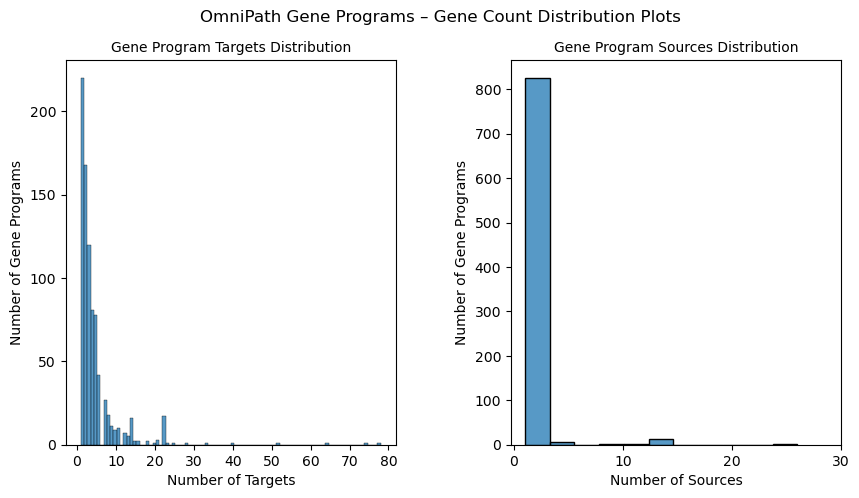

In [17]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=False,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path)
    #plot_gp_gene_count_distributions=True,
    #gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
    #                                       "/omnipath_gp_gene_count_distributions.svg")

In [14]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

NOTCH1_ligand_receptor_GP: {'sources': ['Notch1'], 'targets': ['Notch4', 'Chuk'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor', 'receptor']}


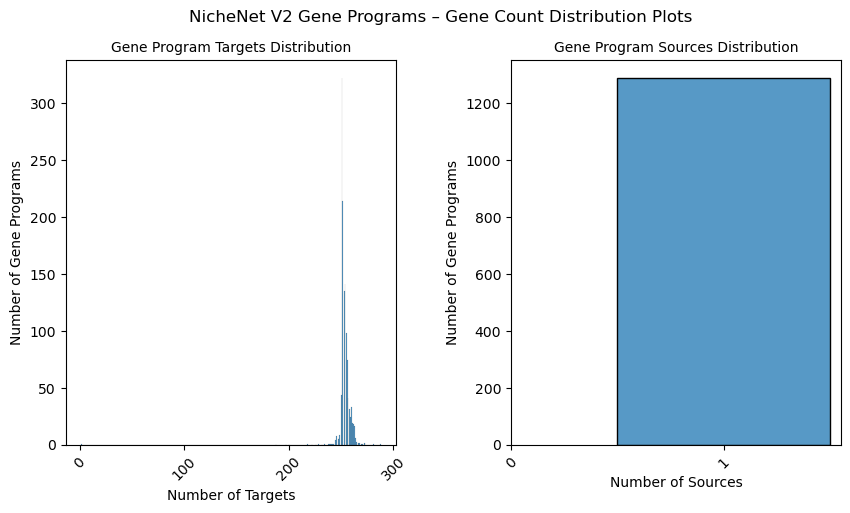

In [15]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    #save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [18]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

C1qa_ligand_receptor_target_gene_GP: {'sources': ['C1qa'], 'targets': ['Cd33', 'Cd93', 'Cr1l', 'Cspg4', 'A2m', 'Adm', 'Akap1', 'Angptl4', 'Ankrd1', 'App', 'Ass1', 'Atf3', 'Bax', 'Bbc3', 'Bcl2', 'Bcl2l1', 'Bcl2l11', 'Bcl3', 'Bcl6', 'Bdnf', 'Bhlhe40', 'Birc3', 'Birc5', 'Bmp4', 'Brca1', 'Btg2', 'C3', 'Cav1', 'Cbx5', 'Ccl12', 'Ccl20', 'Ccl3', 'Ccl5', 'Ccn1', 'Ccn2', 'Ccna2', 'Ccnb1', 'Ccnb1-ps', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Cd44', 'Cdh1', 'Cdk1', 'Cdk4', 'Cdk6', 'Cdkn1a', 'Cdkn1b', 'Cdkn2c', 'Ceacam1', 'Ceacam2', 'Cebpa', 'Cebpb', 'Cflar', 'Cited2', 'Csf2', 'Cxcl1', 'Cxcr4', 'Cyp1b1', 'Cyp3a13', 'Ddit3', 'Ddit4', 'Dhrs3', 'Dkk1', 'Dtl', 'Dusp1', 'Dusp4', 'Dusp5', 'Dusp6', 'E2f1', 'Edn1', 'Egfr', 'Egr1', 'Egr2', 'Egr3', 'Emp1', 'Epha2', 'Esr1', 'Etv4', 'Fas', 'Fasn', 'Fn1', 'Fos', 'Fosl1', 'Foxa1', 'Fst', 'Gadd45a', 'Gadd45b', 'Gadd45g', 'Gapdh', 'Gapdh-ps15', 'Gata3', 'Gdf15', 'Gm10358', 'Gm3839', 'Gm40460', 'Gm4559', 'Gm45618', 'Gm8909', 'H2-D1', 'H2-K1', 'H2-Q1', 'H2-Q10', 'H2-Q2', 'H2-Q4

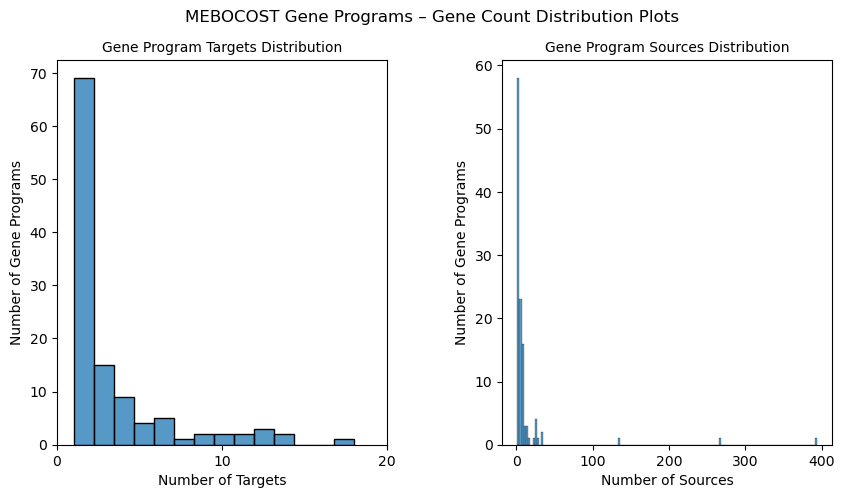

In [19]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [20]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

all-trans-Retinoic acid_metabolite_enzyme_sensor_GP: {'sources': ['Aldh1a1', 'Aldh1a2', 'Aldh1a7'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['Rara', 'Rxra', 'Rxrb', 'Rxrg'], 'targets_categories': ['sensor', 'sensor', 'sensor', 'sensor']}


In [21]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps_v2(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

Combining ACE2_ligand_receptor_GP and Ace2_ligand_receptor_target_gene_GP.
Combining ACE2_ligand_receptor_GP and L-Phenylalanine_metabolite_enzyme_sensor_GP.
Combining ADCYAP1_ligand_receptor_GP and Adcyap1_ligand_receptor_target_gene_GP.
Combining ADGRE5_ligand_receptor_GP and Adgre5_ligand_receptor_target_gene_GP.
Combining ADIPOQ_ligand_receptor_GP and Adipoq_ligand_receptor_target_gene_GP.
Combining ADM_ligand_receptor_GP and Adm_ligand_receptor_target_gene_GP.
Combining ADM2_ligand_receptor_GP and Adm2_ligand_receptor_target_gene_GP.
Combining AGRP_ligand_receptor_GP and Agrp_ligand_receptor_target_gene_GP.
Combining AGT_ligand_receptor_GP and Agt_ligand_receptor_target_gene_GP.
Combining ALCAM_ligand_receptor_GP and Alcam_ligand_receptor_target_gene_GP.
Combining ALKAL1_ligand_receptor_GP and Alkal1_ligand_receptor_target_gene_GP.
Combining ALKAL2_ligand_receptor_GP and Alkal2_ligand_receptor_target_gene_GP.
Combining AMBN_ligand_receptor_GP and Ambn_ligand_receptor_target_gene_G

### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the biological question of interest.

In [101]:
# Read data
adata = sc.read_h5ad("../data/vizgen/vizgen_data.h5ad")

In [24]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Add GP Mask to Data

In [25]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.4 Explore Data

In [26]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

In [26]:
roi=[10000,15000,8000,12000]

Number of nodes (observations): 75890
Number of node features (genes): 347


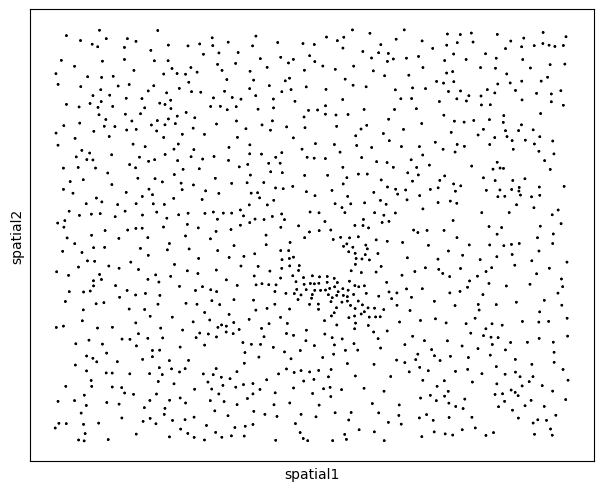

In [61]:
print(f"Number of nodes (observations): {adata.layers['raw_counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['raw_counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
#sc.pl.scatter(adata, basis="spatial",
#              color=cell_type_key)
              #palette=cell_type_colors,
              #spot_size=1)        

sq.pl.spatial_scatter(adata, shape=None, size=3,
                      # x0, y0, x1, y1
                      crop_coord=(10000, 8000, 15000, 12000))

## 3. Train Model

### 3.1 Initialize, Train & Save Model

In [27]:
# Need raw counts as input, also as sparse matrix
import scipy.sparse as sp
adata.layers[counts_key] = sp.csr_matrix(adata.layers[counts_key])
adata.layers['normalized_counts'] = adata.X
adata.X = adata.layers['raw_counts']


In [28]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 347, n_cat_covariates_embed_input: 0, n_hidden: 163, n_latent: 63, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 63, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 347
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 63, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 347


In [29]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 68301
Number of validation nodes: 7589
Number of training edges: 196672
Number of validation edges: 21852
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 504575.6537; train_optim_loss: 504575.6537; val_global_loss: 448186.8849; val_optim_loss: 448186.8849
Epoch 2/400 |--------------------| 0.5% train_global_loss: 435421.4519; train_optim_loss: 435421.4519; val_global_loss: 431549.4886; val_optim_loss: 431549.4886
Epoch 3/400 |--------------------| 0.8% train_global_loss: 422822.5291; train_optim_loss: 422822.5291; val_global_loss: 423245.5795; val_optim_loss: 423245.5795
Epoch 4/400 |--------------------| 1.0% train_global_loss: 416085.4938; train_optim_loss: 416085.4938; val_global_loss: 417660.9446; val_optim_loss: 417660.9446
Epoch 5/400 |--------------------| 1.2% train_global_loss: 412347.1608; train_optim_loss: 412347.1608; val_global_loss: 416503

In [30]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [31]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="vizgen_nichecompass.h5ad")

## 4. Analysis

In [32]:
load_timestamp = "16012026_122133"
# load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [33]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="vizgen_nichecompass.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 347, n_cat_covariates_embed_input: 0, n_hidden: 163, n_latent: 63, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 63, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 347
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 63, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 347


In [38]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Latent GP Space

Let's look at the preservation of cell type annotations in the latent GP space. Note that the goal of NicheCompass is not a separation of cell types but rather to identify spatially consistent cell niches.

In [39]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

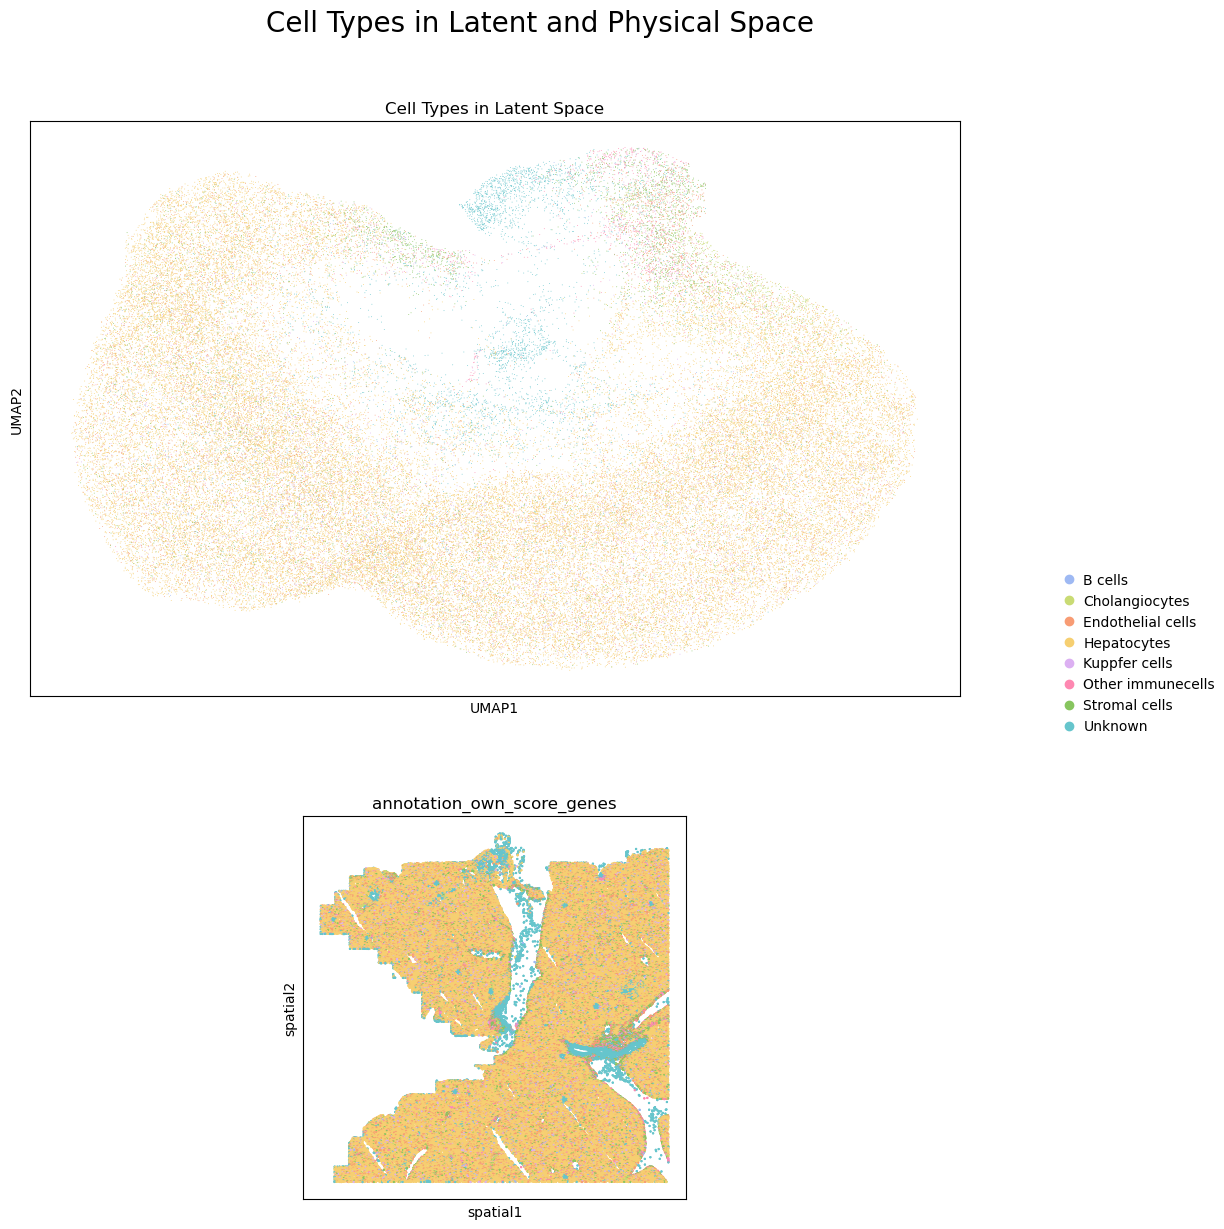

In [55]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    
    sq.pl.spatial_scatter(adata = model.adata[model.adata.obs[sample_key] == sample],
                          groups=groups,
                          img=False,
                          color=[cell_type_key],
                          #palette=cell_type_colors,
                          shape=None,
                          #title=f"Cell Types in Physical Space \n",
                          #      f"(Sample: {sample})",
                          legend_loc=None,
                          ax=axs[idx+1])
    
    # sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
    #               color=[cell_type_key],
    #               groups=groups,
    #               palette=cell_type_colors,
    #               spot_size=spot_size,
    #               title=f"Cell Types in Physical Space \n"
    #                     f"(Sample: {sample})",
    #               legend_loc=None,
    #               ax=axs[idx+1],
    #               show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

In [ ]:
sc.pl.umap(adata=model.adata,
           color="",
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)

### 4.2 Identify Niches

We compute Leiden clustering of the NicheCompass latent GP space to identify spatially consistent cell niches.

In [58]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [61]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

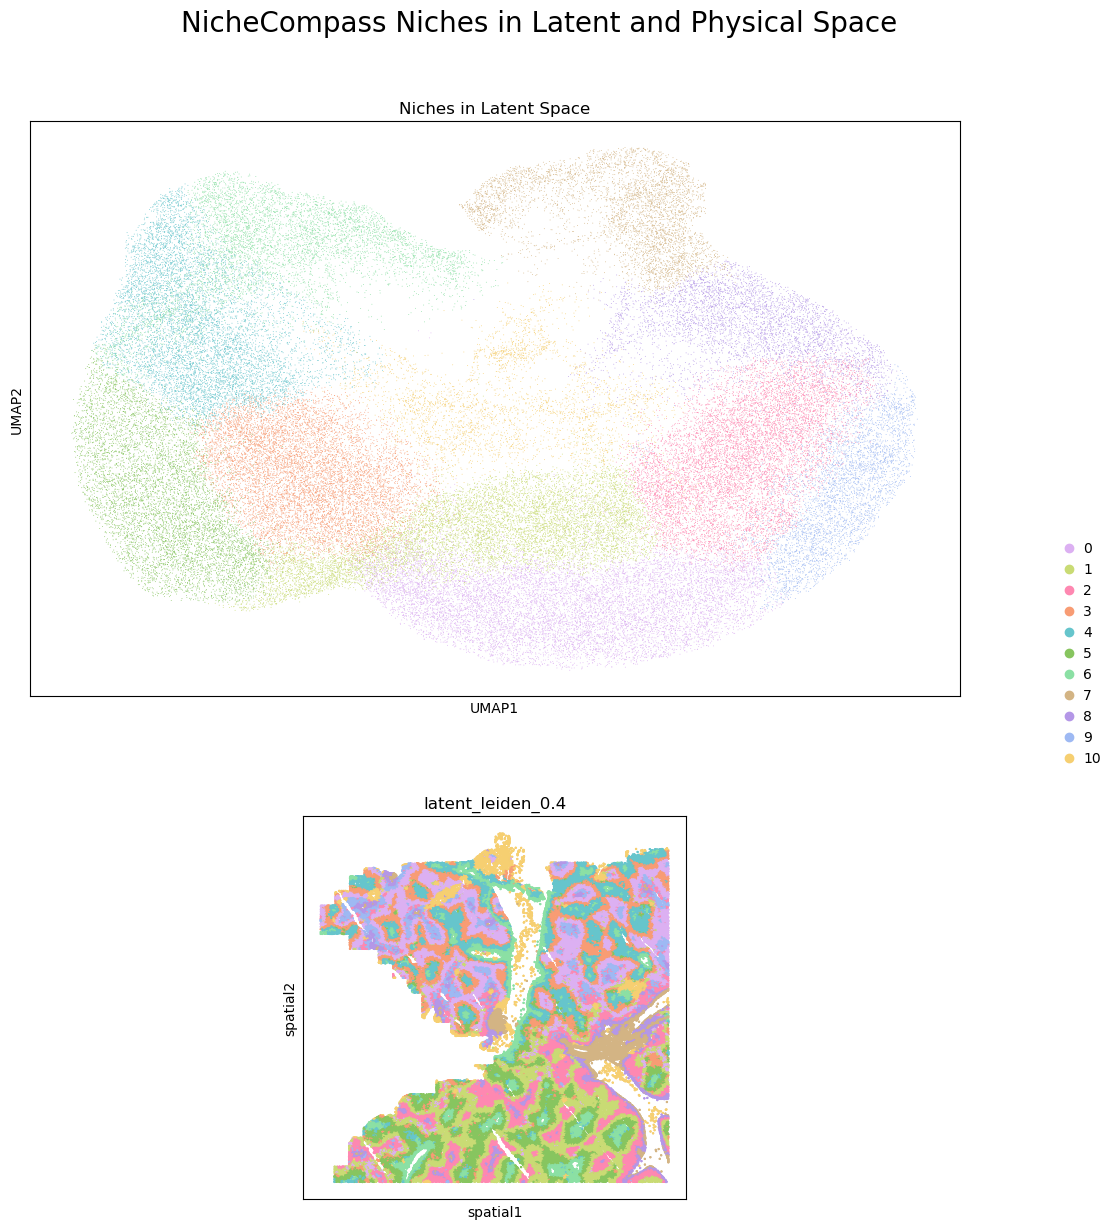

In [63]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sq.pl.spatial_scatter(adata = model.adata[model.adata.obs[sample_key] == sample],
                      groups=groups,
                      img=False,
                      color=[latent_cluster_key],
                      #palette=latent_cluster_colors,
                      shape=None,
                      #title=f"Cell Types in Physical Space \n",
                      #      f"(Sample: {sample})",
                      legend_loc=None,
                      ax=axs[idx+1])
    # sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
    #               color=[latent_cluster_key],
    #               groups=groups,
    #               palette=latent_cluster_colors,
    #               spot_size=spot_size,
    #               title=f"Niches in Physical Space \n"
    #                     f"(Sample: {sample})",
    #               legend_loc=None,
    #               ax=axs[idx+1],
    #               show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Characterize Niches

Now we will characterize the identified cell niches.

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of cell type labels.

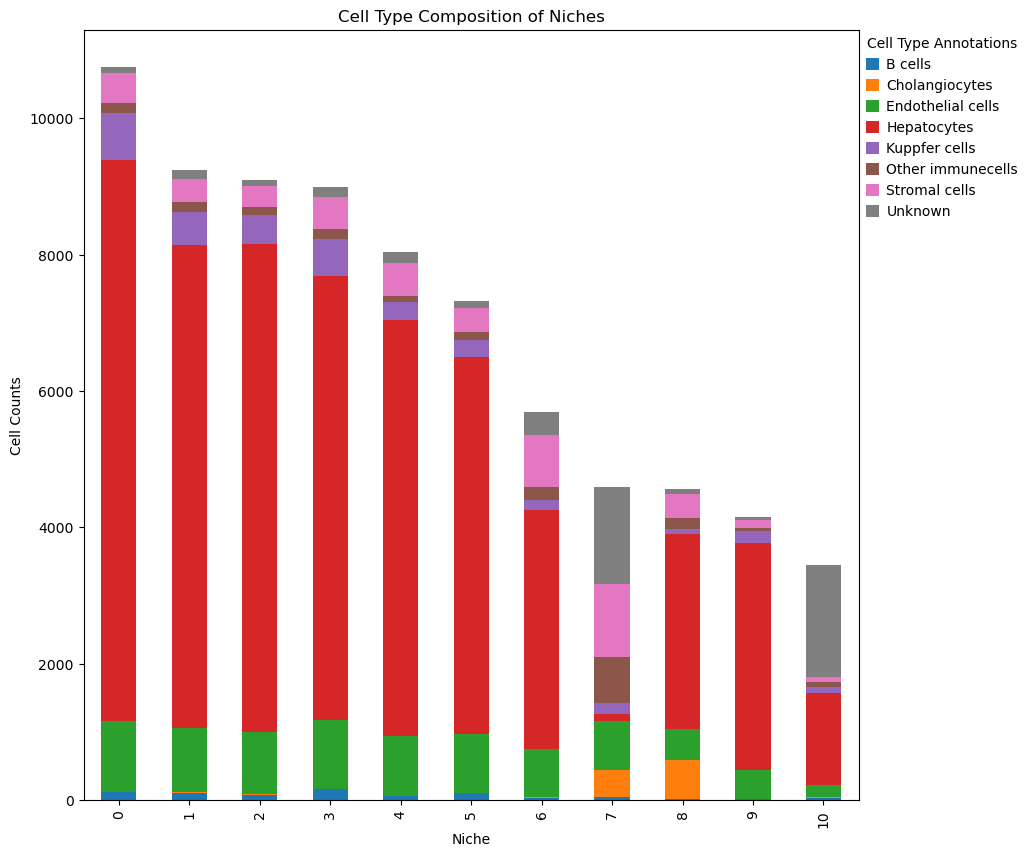

In [64]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### Save files

In [89]:
model.adata

AnnData object with n_obs × n_vars = 75890 × 347
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'Endothelial cells', 'Stromal cells', 'Hepatocytes', 'Cholangiocytes', 'HsPCs', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kuppfer cells', 'Cleanliness', 'annotation', 'Hep', 'score_celltype_own_score_genes', 'second_score_celltype_own_score_genes', 'cleanliness_own_score_genes', 'annotation_own_score_genes_start_iterative', 'annotation_own_score_genes', 'latent_leiden_0.4', 'Timp3_ligand_receptor_target_gene_GP', 'ANGPT2_combined_GP', 'WNT2_combined_GP', 'Add-on_38_GP', 'Add-on_35_GP', 'WNT4_combined_GP', 'BMP5_combined_GP', 'Sfrp1_ligand_receptor_target_gene_GP', 'Serping1_ligand_receptor_target_gene_GP', 'Selplg_ligand_re

In [114]:


output_file_path = f"../rds/vizgen_nichecompass_latent_clusters_and_umap.csv"
obs_data = model.adata.obs[[latent_cluster_key]]
umap_data = pd.DataFrame(model.adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=model.adata.obs_names)
combined_data = pd.concat([obs_data, umap_data], axis=1)
combined_data.to_csv(output_file_path)

#### 4.3.2 Differential GPs

Now we can test which GPs are differentially expressed in a niche. To this end, we will perform "one-vs-rest" differential GP testing, i.e all niches (```selected_cats = None```) are tested against all other niches (```comparison_cats = "rest"```). However, differential GP testing can also be performed in the following ways:
- Set ```selected_cats = ["0"]``` to perform differential GP testing for a specific niche only, in this case niche "0".
- Set ```comparison_cats = ["2"]``` to perform differential GP testing against niche "2" as opposed to against all other niches.

We choose an absolute log bayes factor threshold of 2.3 to determine strongly enriched GPs (see https://en.wikipedia.org/wiki/Bayes_factor).

In [65]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 163.
Number of active gene programs: 72.


In [66]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

gp_name  all_gp_idx  gp_active  active_gp_idx  \
0            CD177_ligand_receptor_GP           0       True              0   
1              KDR_ligand_receptor_GP           1       True              1   
2              KIT_ligand_receptor_GP           2       True              2   
3           NOTCH1_ligand_receptor_GP           3       True              3   
4  Ace_ligand_receptor_target_gene_GP           4       True              4   

   n_source_genes  n_non_zero_source_genes  n_target_genes  \
0               1                        1               1   
1               1                        1               1   
2               1                        1               1   
3               1                        1               1   
4               1                        1              17   

   n_non_zero_target_genes gp_source_genes  \
0                        1         [Cd177]   
1                        1           [Kdr]   
2                        1           [Kit]   
3                        1        [Notch1]   
4                       17           [Ace]   

                                     gp_target_genes gp_source_genes_weights  \
0                                           [Pecam1]               [-0.0534]   
1                                             [Nrp1]                [0.0458]   
2                                             [Il7r]               [-0.1059]   
3                                           [Notch4]                [0.1036]   
4  [Fstl1, Epas1, Fasn, Cyp1a1, G6pc, Ldha, Cebpa...                [0.1227]   

                             gp_target_genes_weights  \
0                                           [0.0238]   
1                                           [0.0606]   
2                                           [0.0186]   
3                                          [-0.0279]   
4  [-1.5305, 1.4375, 1.3014, -1.2885, 1.224, 1.21...   

  gp_source_genes_importances  \
0                    [0.6918]   
1                    [0.4306]   
2                    [0.8503]   
3                    [0.7878]   
4                      [0.01]   

                         gp_target_genes_importances  
0                                           [0.3082]  
1                                           [0.5694]  
2                                           [0.1497]  
3                                           [0.2122]  
4  [0.1245, 0.117, 0.1059, 0.1048, 0.0996, 0.0987...

In [67]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [68]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Filter gp_summary_df for rows where 'gp_name' contains 'combined'
gp_summary_df[gp_summary_df['gp_name'].str.contains('combined', case=False)]

gp_name  all_gp_idx  gp_active  active_gp_idx  n_source_genes  \
29   ALCAM_combined_GP          29       True             29               1   
30  ANGPT1_combined_GP          30       True             30               1   
31  ANGPT2_combined_GP          31       True             31               1   
32    BMP2_combined_GP          32       True             32               1   
33    BMP5_combined_GP          33       True             33               1   
34    BMP7_combined_GP          34       True             34               1   
35    CD34_combined_GP          35       True             35               1   
36    CD48_combined_GP          36       True             36               1   
37  CXCL12_combined_GP          37       True             37               1   
38  CXCL14_combined_GP          38       True             38               1   
39    DKK1_combined_GP          39       True             39               1   
40    DKK2_combined_GP          40       True             40               1   
41    DLL1_combined_GP          41       True             41               1   
42    DLL4_combined_GP          42       True             42               1   
43   EFNB2_combined_GP          43       True             43               1   
44    FGF1_combined_GP          44       True             44               1   
45    FGF2_combined_GP          45       True             45               1   
46     GRN_combined_GP          46       True             46               1   
47     HGF_combined_GP          47       True             47               1   
48   ICAM1_combined_GP          48       True             48               1   
49    IGF1_combined_GP          49       True             49               1   
50     IL6_combined_GP          50       True             50               1   
51    JAG1_combined_GP          51       True             51               1   
52    JAG2_combined_GP          52       True             52               1   
53   KITLG_combined_GP          53       True             53               1   
54    NID1_combined_GP          54       True             54               1   
55    NRP1_combined_GP          55       True             55               1   
56  PECAM1_combined_GP          56       True             56               1   
57   SFRP2_combined_GP          57       True             57               1   
58   TGFB2_combined_GP          58       True             58               1   
59   VCAM1_combined_GP          59       True             59               1   
60     VWF_combined_GP          60       True             60               1   
61    WNT2_combined_GP          61       True             61               1   
62    WNT4_combined_GP          62       True             62               1   

    n_non_zero_source_genes  n_target_genes  n_non_zero_target_genes  \
29                        1              11                       11   
30                        1              18                       18   
31                        1              20                       20   
32                        1              14                       14   
33                        1              20                       20   
34                        1              16                       16   
35                        1              12                       12   
36                        1              13                       13   
37                        1               6                        6   
38                        1              13                       13   
39                        1              14                       14   
40                        1              14                       14   
41                        1              18                       18   
42                        1              11                       11   
43                        1              19                       19   
44                        1              12                   

In [80]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

category                           gene_program      p_h0      p_h1  \
0         7   Timp3_ligand_receptor_target_gene_GP  0.003552  0.996448   
1         7                     ANGPT2_combined_GP  0.994252  0.005748   
2         7                       WNT2_combined_GP  0.993938  0.006062   
3         7                           Add-on_38_GP  0.007296  0.992704   
4         7                           Add-on_35_GP  0.008171  0.991829   
..      ...                                    ...       ...       ...   
66        6     Eng_ligand_receptor_target_gene_GP  0.088018  0.911982   
67       10  Col6a1_ligand_receptor_target_gene_GP  0.088699  0.911301   
68        9    Dkk3_ligand_receptor_target_gene_GP  0.088858  0.911142   
69        1                       JAG2_combined_GP  0.089731  0.910269   
70        7                        IL6_combined_GP  0.910163  0.089837   

    log_bayes_factor  
0          -5.636593  
1           5.153195  
2           5.099631  
3          -4.913095  
4          -4.798951  
..               ...  
66         -2.338079  
67         -2.329624  
68         -2.327654  
69         -2.316922  
70          2.315624  

[71 rows x 5 columns]

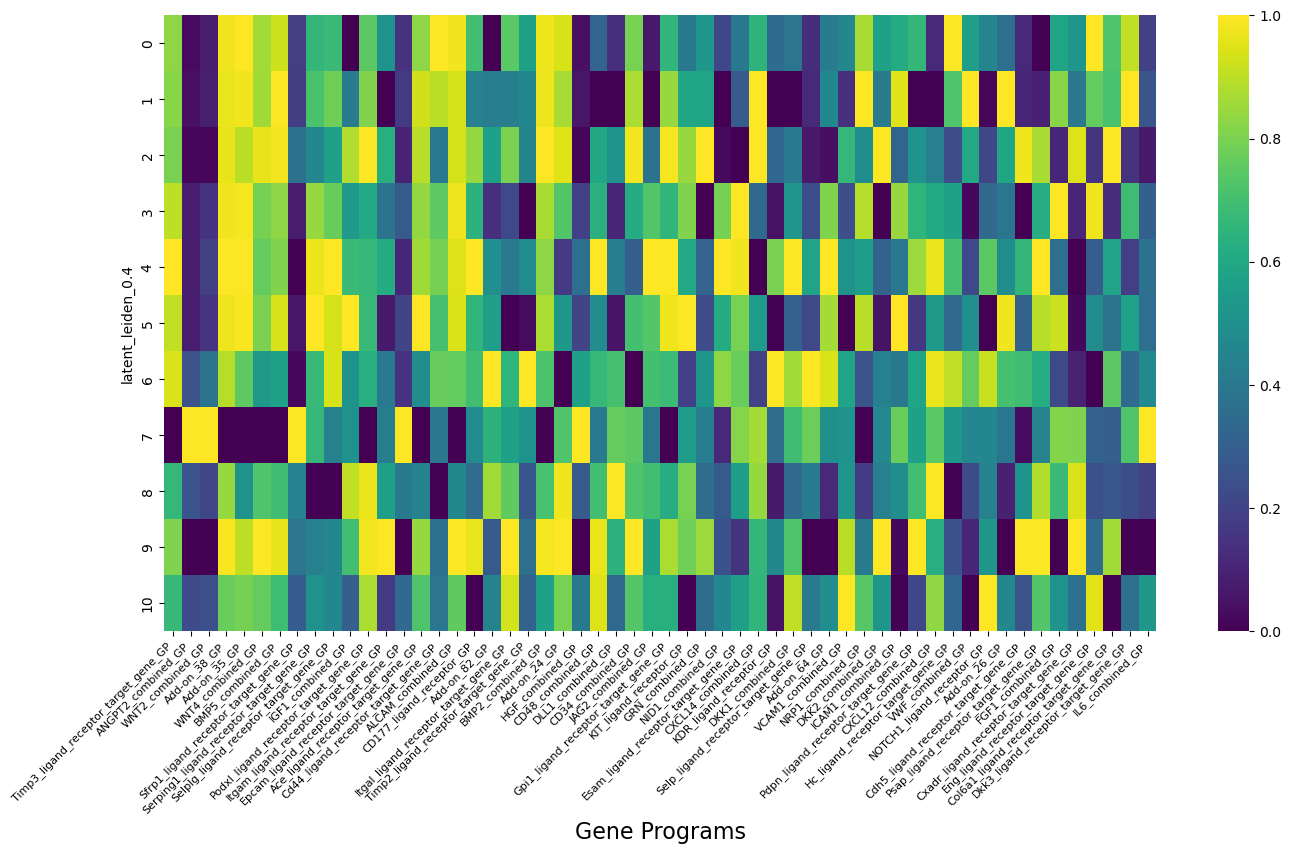

In [81]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [82]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

Now we will have a look at the GP activities and the log normalized counts of
the most important omics features of the differential GPs.

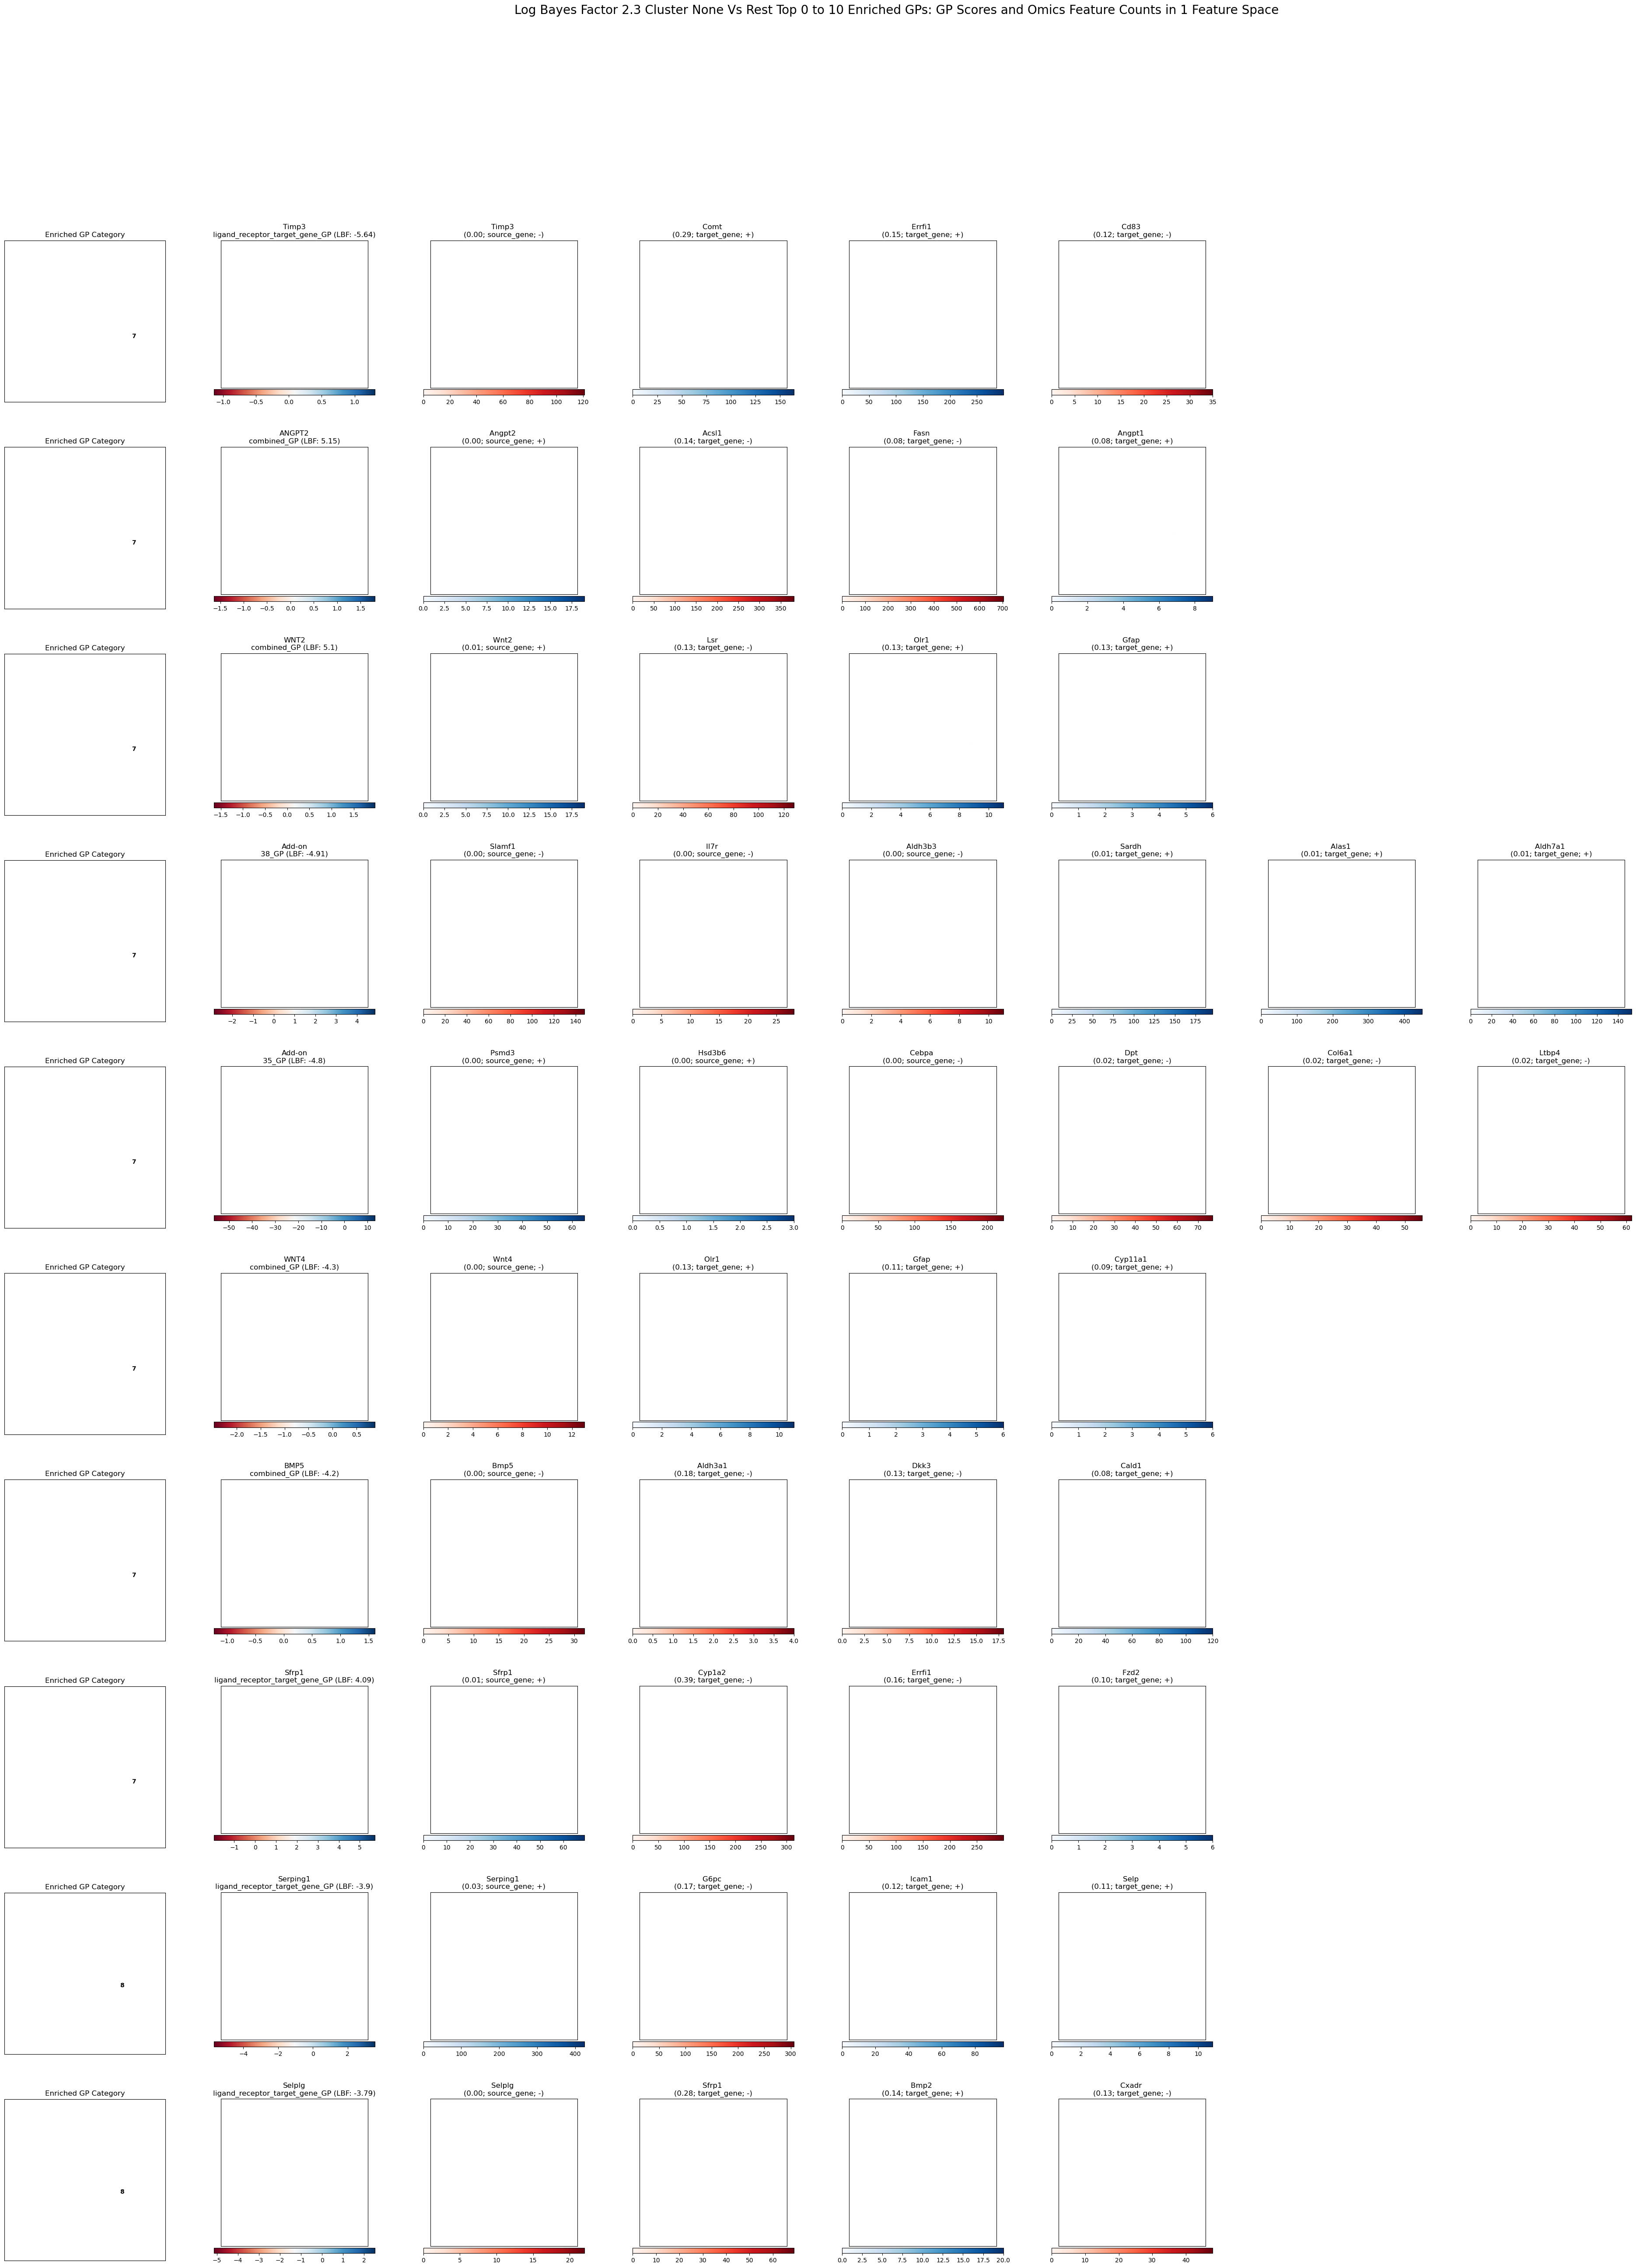

In [83]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0] if selected_cats else 'None'}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 4.3.3 Cell-cell Communication

Now we will use the inferred activity of an enriched combined interaction GP to analyze the involved intercellular interactions.

In [87]:
gp_name = "CCK_combined_GP"

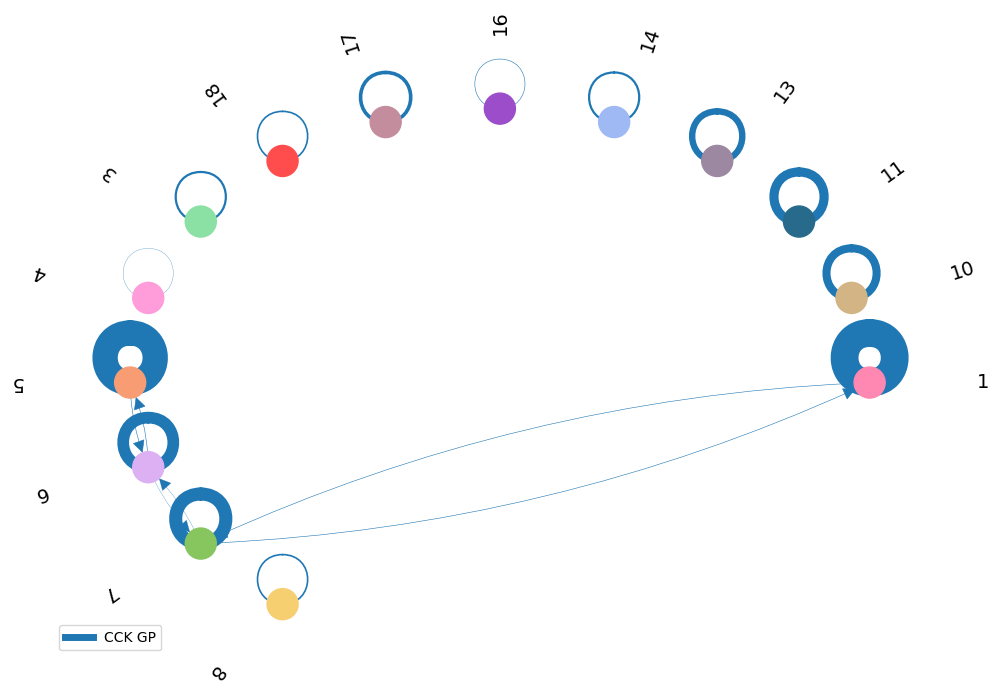

In [90]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(10, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )